In [1]:
import os
from pathlib import Path
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler, StableUnCLIPImg2ImgPipeline
from diffusers.utils import load_image
import torch
from torch import nn
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision.io import read_image
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_context("paper")
sns.set_style("ticks")
import time
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

import sys
sys.path.append('./dataset-interfaces/')
from dataset_interfaces import utils
from dataset_interfaces import run_textual_inversion
from dataset_interfaces import generate
import dataset_interfaces.imagenet_utils as in_utils
import dataset_interfaces.inference_utils as infer_utils

path_imagenet = os.path.expandvars('$DSDIR/imagenet') # '/scratchf/'
path_pretrained = Path(os.path.expandvars('$WORK/MODELS'))
path_huggingface = os.path.expandvars('$DSDIR/HuggingFace_Models/') 
path_results = Path(os.path.expandvars('$WORK/semantics/results/domains'))

BATCH_SIZE = 256

In [ ]:
class CategoryClassifier(nn.Module):
    def __init__(self, category='dog'):
        super().__init__()
        weights = ViT_B_16_Weights.DEFAULT
        self.preprocess = weights.transforms()
        self.classifier = vit_b_16(weights=weights)
        self.classifier.eval()
        imagenet_categories = pd.read_csv('../../DATA/imagenet_categories_synset.csv')
        self.category_indices = (imagenet_categories.loc[imagenet_categories['categories'] == category, 'index']).to_numpy()
        self.rest_indices = (imagenet_categories.loc[imagenet_categories['categories'] != category, 'index']).to_numpy()
        
    def forward(self, x, preprocess=False):
        if preprocess:
            if isinstance(x, list):
                x = torch.stack([self.preprocess(x_i) for x_i in x]).to('cuda')
            else:
                raise NotImplementedError()
        logits = self.classifier(x)
        probas = torch.softmax(logits, axis=1)
        probas_category = probas[:, self.category_indices].sum(dim=1, keepdim=True)
        probas_rest = probas[:, self.rest_indices].sum(dim=1, keepdim=True)
        probas = torch.cat((probas_category, probas_rest), axis=1)
        return probas

dog_classifier = CategoryClassifier('dog')
dog_classifier = dog_classifier.cuda()

img = read_image('./dog.jpg').cuda()
img = dog_classifier.preprocess(img).unsqueeze(0)
out = dog_classifier(img)
out

/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.1.1+py3.11.5/lib/python3.11/site-packages/torchvision-0.16.1+fdea156-py3.11-linux-x86_64.egg/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([[0.9209, 0.0791]], device='cuda:0', grad_fn=<CatBackward0>)

# Tests

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

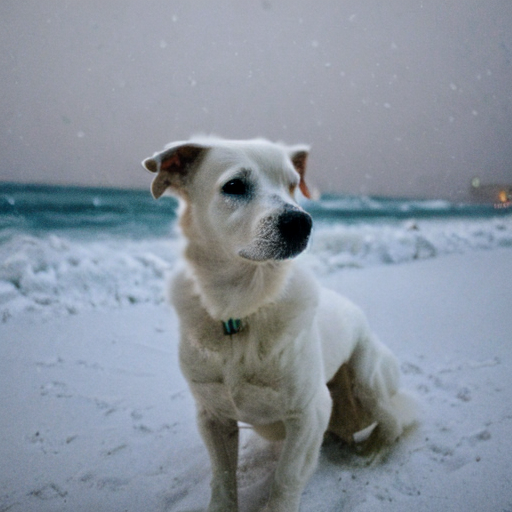

In [3]:
# Stable Diffusion

repo_id = str(path_pretrained / 'stabilityai--stable-diffusion-2-1-base')
pipe = DiffusionPipeline.from_pretrained(repo_id, torch_dtype=torch.float16, revision='fp16', use_safetensors=True)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

prompt = "a white dog at the beach, during nighttime, it is snowing"
image = pipe(prompt).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

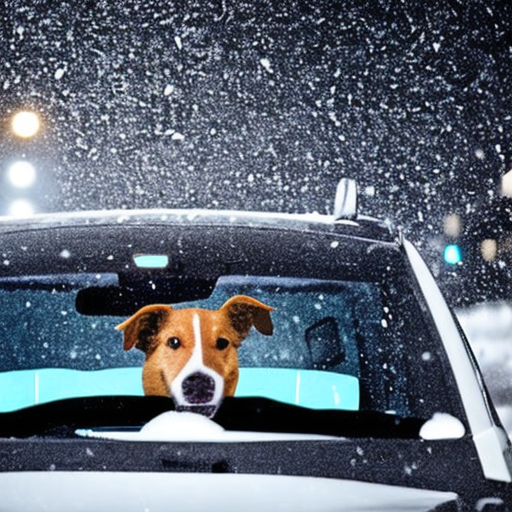

In [6]:
prompt = "front view of a dog in a car, during nighttime, it is snowing"
image = pipe(prompt).images[0]
image

In [ ]:
# UnCLIP image variation

repo_id = str(path_pretrained / 'stabilityai--stable-diffusion-2-1-unclip')
pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(repo_id, torch_dtype=torch.float16, variation="fp16", use_safetensors=True)
pipe = pipe.to("cuda")

url = "./dog.jpg"
init_image = load_image(url)

prompt = "in the forest, with sunglasses"
image = pipe(init_image, prompt=prompt, noise_level=0).images[0]
image

In [ ]:
# UnCLIP small image variation

repo_id = str(path_pretrained / 'stabilityai--stable-diffusion-2-1-unclip-small')
pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(repo_id, torch_dtype=torch.float16, variation="fp16", use_safetensors=True)
pipe = pipe.to("cuda")

url = "./gugong.jpg"
init_image = load_image(url)

prompt = "in the snow"
images = pipe(init_image, prompt=prompt).images
images[0].save("variation_image2.png")

# Show results

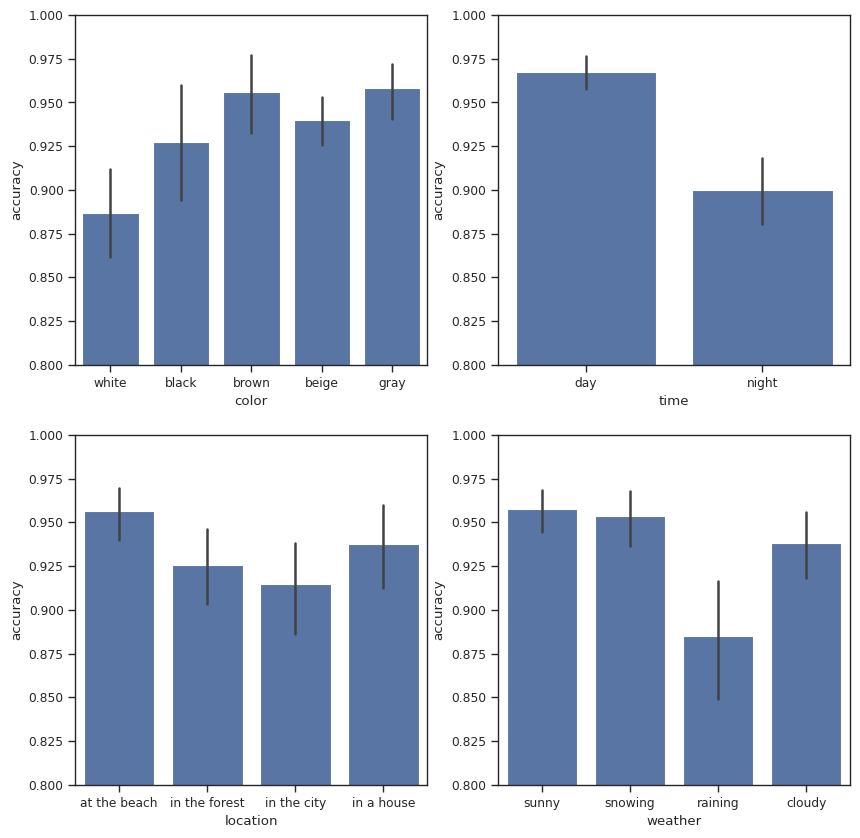

In [3]:
exp = '20240112_1548_filtered'

df = pd.read_csv(path_results / exp / 'results.csv')

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, attribute in enumerate(['color', 'time', 'location', 'weather']):
    sns.barplot(df, x=attribute, y='accuracy', ax=axs.flatten()[i])
    axs.flatten()[i].set_ylim(0.8, 1)

proba dog: 0.02


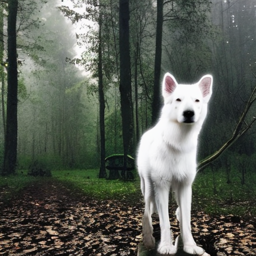

In [27]:
# show sample of incorrect
 
combination_id = 23
print(df[df['id'] == combination_id])

img_id = 23
img = read_image(str(path_results / exp / str(combination_id) / f'{img_id}.png'))
img = dog_classifier.preprocess(img).unsqueeze(0).cuda()
with torch.no_grad():
    out = dog_classifier(img) Jun 17th,

# couverture risque

Text(0, 0.5, 'accuracy')

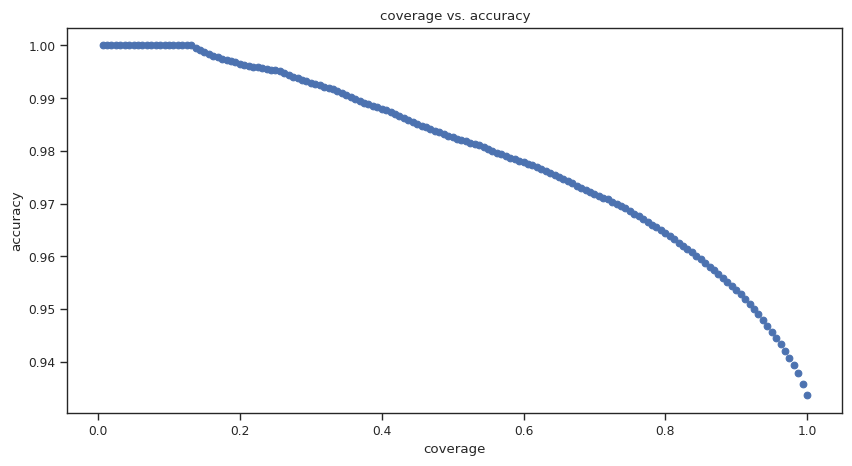

In [29]:
# Using domain on synthetic data

sorted_ids = df.sort_values('accuracy', ascending=False)['id'].to_numpy()

domain_cutoff = np.arange(1, len(df)+1)
coverage = np.zeros(domain_cutoff.shape)
accuracy = np.zeros(domain_cutoff.shape)
for i, cut in enumerate(domain_cutoff):
    ids = sorted_ids[:cut]
    coverage[i] = df.loc[df['id'].isin(ids), 'nb_images'].sum() / df['nb_images'].sum()
    accuracy[i] = np.average(df.loc[df['id'].isin(ids), 'accuracy'], weights=df.loc[df['id'].isin(ids), 'nb_images'])

# plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax1.set_title(f'coverage vs. accuracy')
ax1.scatter(coverage, accuracy)
ax1.set_xlabel('coverage')
ax1.set_ylabel('accuracy')

/tmp/ipykernel_113929/301339298.py:22: RuntimeWarning: Mean of empty slice.
  acc_baseline[i] = correct[idx_domain].mean()
/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.1.1+py3.11.5/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'accuracy')

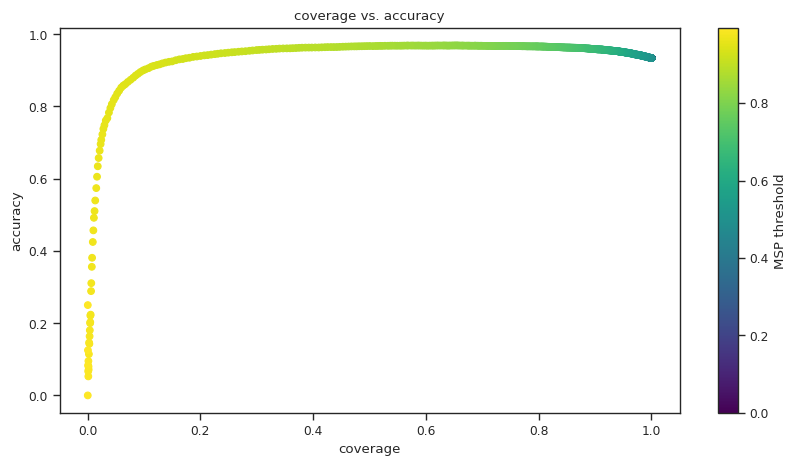

In [30]:
# Using MSP on synthetic data (because binary case, many wrong predictions have high confid, so accuracy at low coverage is low)

all_paths = list((path_results / exp).glob('*/*.png'))
msp = np.zeros(len(all_paths))
correct = np.zeros(len(all_paths))

for i, pth in enumerate(all_paths):
    img = read_image(str(pth))
    img = dog_classifier.preprocess(img).unsqueeze(0).cuda()
    with torch.no_grad():
        out = dog_classifier(img)
    msp[i] = out.max(1).values
    correct[i] = (out.argmax(1) == 0)

domain_cutoff_baseline = np.linspace(0, 1, 1000)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
risk_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = msp > cut
    coverage_baseline[i] = idx_domain.mean()
    acc_baseline[i] = correct[idx_domain].mean()

# plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax1.set_title(f'coverage vs. accuracy')
sc = ax1.scatter(coverage_baseline, acc_baseline, c=domain_cutoff_baseline, cmap='viridis')
fig.colorbar(sc, ax=ax1, label='MSP threshold')
ax1.set_xlabel('coverage')
ax1.set_ylabel('accuracy')

/tmp/ipykernel_113929/551266610.py:22: RuntimeWarning: Mean of empty slice.
  acc_baseline[i] = correct[idx_domain].mean()
/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.1.1+py3.11.5/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'accuracy')

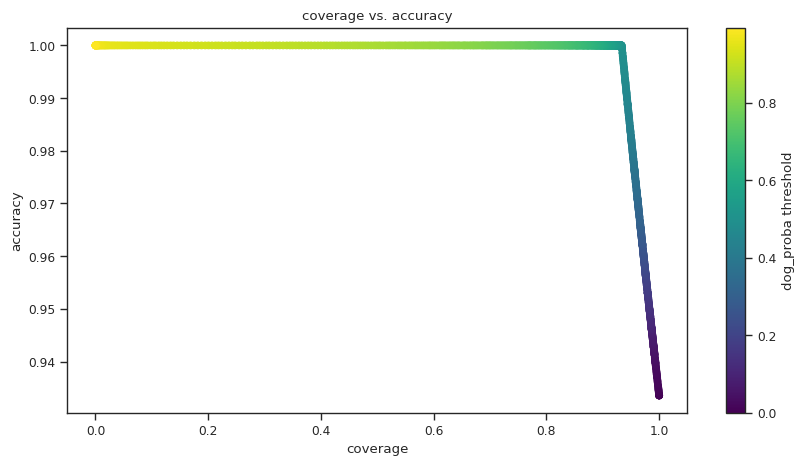

In [33]:
# Using dog proba on synthetic data (dog proba is true class proba)

all_paths = list((path_results / exp).glob('*/*.png'))
dog_proba = np.zeros(len(all_paths))
correct = np.zeros(len(all_paths))

for i, pth in enumerate(all_paths):
    img = read_image(str(pth))
    img = dog_classifier.preprocess(img).unsqueeze(0).cuda()
    with torch.no_grad():
        out = dog_classifier(img)
    dog_proba[i] = out[0][0].item()
    correct[i] = (out.argmax(1) == 0)

domain_cutoff_baseline = np.linspace(0, 1, 1000)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
risk_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = dog_proba > cut
    coverage_baseline[i] = idx_domain.mean()
    acc_baseline[i] = correct[idx_domain].mean()

# plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax1.set_title(f'coverage vs. accuracy')
sc = ax1.scatter(coverage_baseline, acc_baseline, c=domain_cutoff_baseline, cmap='viridis')
fig.colorbar(sc, ax=ax1, label='dog_proba threshold')
ax1.set_xlabel('coverage')
ax1.set_ylabel('accuracy')

/tmp/ipykernel_113929/4079567296.py:31: RuntimeWarning: Mean of empty slice.
  acc_baseline[i] = all_correct[idx_domain].mean()
/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.1.1+py3.11.5/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'accuracy')

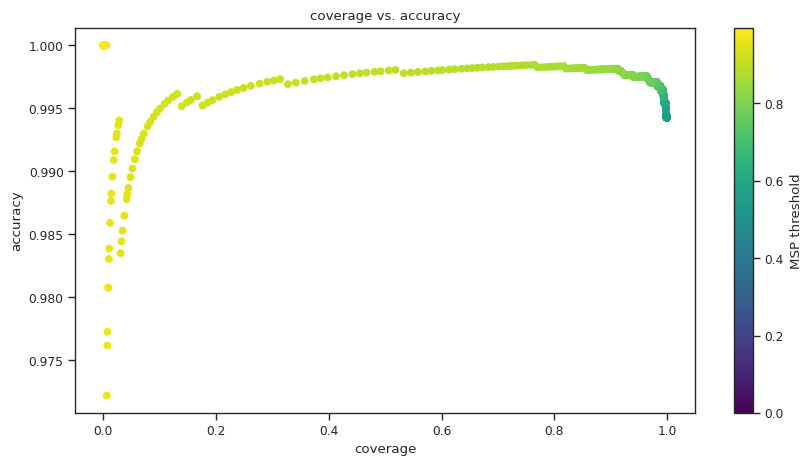

In [38]:
# Using MSP on validation data

dataset_val = ImageFolder(path_imagenet+'/val', transform=dog_classifier.preprocess)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=True)

# Test loop
all_msp = []
all_correct = []
for images, labels in dataloader_val:
    images = images.cuda()
    # keep only considered category
    idx = torch.isin(labels, torch.tensor(dog_classifier.category_indices))
    images = images[idx]
    with torch.no_grad():
        probas = dog_classifier(images)
    msp, pred = probas.max(1)
    correct = (pred == 0) # prediction should be dog
    all_msp.append(msp)
    all_correct.append(correct)
all_msp = torch.cat(all_msp).cpu().numpy()
all_correct = torch.cat(all_correct).cpu().numpy()


domain_cutoff_baseline = np.linspace(0, 1, 1000)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
risk_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = all_msp > cut
    coverage_baseline[i] = idx_domain.mean()
    acc_baseline[i] = all_correct[idx_domain].mean()

# plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax1.set_title(f'coverage vs. accuracy')
sc = ax1.scatter(coverage_baseline, acc_baseline, c=domain_cutoff_baseline, cmap='viridis')
fig.colorbar(sc, ax=ax1, label='MSP threshold')
ax1.set_xlabel('coverage')
ax1.set_ylabel('accuracy')

# Predict attributes

In [3]:
exp = '20240112_1548_filtered'

nb_prompts = sum(1 for _ in (path_results / exp).rglob('*') if _.is_dir() and not _.name.startswith('.'))
list_prompts = []
for i in range(nb_prompts):
    with open((path_results / exp / f'{i}' / 'prompt.txt'), 'r') as f:
        list_prompts.append(f.read())


class SubdomainPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.CLIP_model = CLIPModel.from_pretrained(path_huggingface+"openai/clip-vit-large-patch14")
        self.CLIP_processor = CLIPProcessor.from_pretrained(path_huggingface+"openai/clip-vit-large-patch14")

    def forward(self, images):
        with torch.no_grad():
            inputs = self.CLIP_processor(text=list_prompts, images=images, return_tensors="pt", padding=True)
            outputs = self.CLIP_model(**inputs)
        logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
        probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
        return probs
        
subdomain_predictor = SubdomainPredictor()

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


### for new data

In [4]:
all_correct = []
for i in range(nb_prompts):
    images = [Image.open(path_results / exp / f'{i}/{j}.png') for j in range(100)]
    pred = subdomain_predictor(images).argmax(1)
    correct = (pred == i)
    all_correct.append(correct)
    if i>0: stop

NameError: name 'stop' is not defined

In [6]:
i = 3
images = [Image.open(path_results / exp / f'{i}/{j}.png') for j in range(100)]
pred = subdomain_predictor(images).argmax(1)
correct = (pred == i)
correct.float().mean()

tensor(1.)

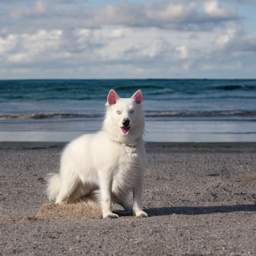

In [7]:
images[0]

### for val set

In [16]:
f_path_test = path_results / 'results_val.csv'

if f_path_test.exists():
    df = pd.read_csv(f_path_test)
else:
    dataset_val = ImageFolder(path_imagenet+'/val', transform=dog_classifier.preprocess)
    dataset_val_raw = ImageFolder(path_imagenet+'/val', transform=transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()]))

    dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=False)
    dataloader_val_raw = DataLoader(dataset_val_raw, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=False)

    # Test loop
    all_msp = []
    all_correct = []
    for images, labels in dataloader_val:
        images = images.cuda()
        # keep only considered category
        idx = torch.isin(labels, torch.tensor(dog_classifier.category_indices))
        images = images[idx]
        if images.shape[0] > 0:
            with torch.no_grad():
                probas = dog_classifier(images)
            msp, pred = probas.max(1)
            correct = (pred == 0) # prediction should be dog
            all_msp.append(msp)
            all_correct.append(correct)
        else:
            continue
    all_msp = torch.cat(all_msp).cpu().numpy()
    all_correct = torch.cat(all_correct).cpu().numpy()
    print(f'Val accuracy {np.mean(all_correct):.2f}')

    all_subdomain_pred = []
    for images, labels in dataloader_val_raw:
        images = images.cuda()
        # keep only considered category
        idx = torch.isin(labels, torch.tensor(dog_classifier.category_indices))
        images = images[idx]
        if images.shape[0] > 0:
            with torch.no_grad():
                subdomain_pred = subdomain_predictor(images*255).argmax(1)
            all_subdomain_pred.append(subdomain_pred)
        else:
            continue
    all_subdomain_pred = torch.cat(all_subdomain_pred)
    pred_prompts = [list_prompts[p] for p in all_subdomain_pred]

    # save stats
    category = 'dog'
    domain_color = ['white', 'black', 'brown', 'beige', 'gray']
    domain_time = ['day', 'night']
    domain_location = ['at the beach', 'in the forest', 'in the city', 'in a house']
    domain_weather = ['sunny', 'snowing', 'raining', 'cloudy']
    combination_id = 0
    for color in domain_color:
        for time_ in domain_time:
            for location in domain_location:
                for weather in domain_weather:

                    prompt = f'a {color} {category} {location}, during the {time_}, it is {weather}'

                    img_ids = [i for i, p in enumerate(pred_prompts) if p == prompt]

                    id_incorrect = [i for i in img_ids if all_correct[i] == False]

                    df = pd.DataFrame({'id': combination_id, 'nb_images': len(img_ids), 'category': [category], 'color': [color], 'time': [time_], 'location': [location], 'weather': [weather], 
                                        'accuracy': np.mean(all_correct[img_ids]), 'average_confidence': np.mean(all_msp[img_ids]), 'id_incorrect': [id_incorrect], 'img_ids': [img_ids]})

                    f_path_test = path_results / 'results_val.csv'
                    if f_path_test.exists():
                        df_0 = pd.read_csv(f_path_test)
                        df = pd.concat([df_0, df], axis=0)
                    df.to_csv(f_path_test, index=False)

                    combination_id += 1

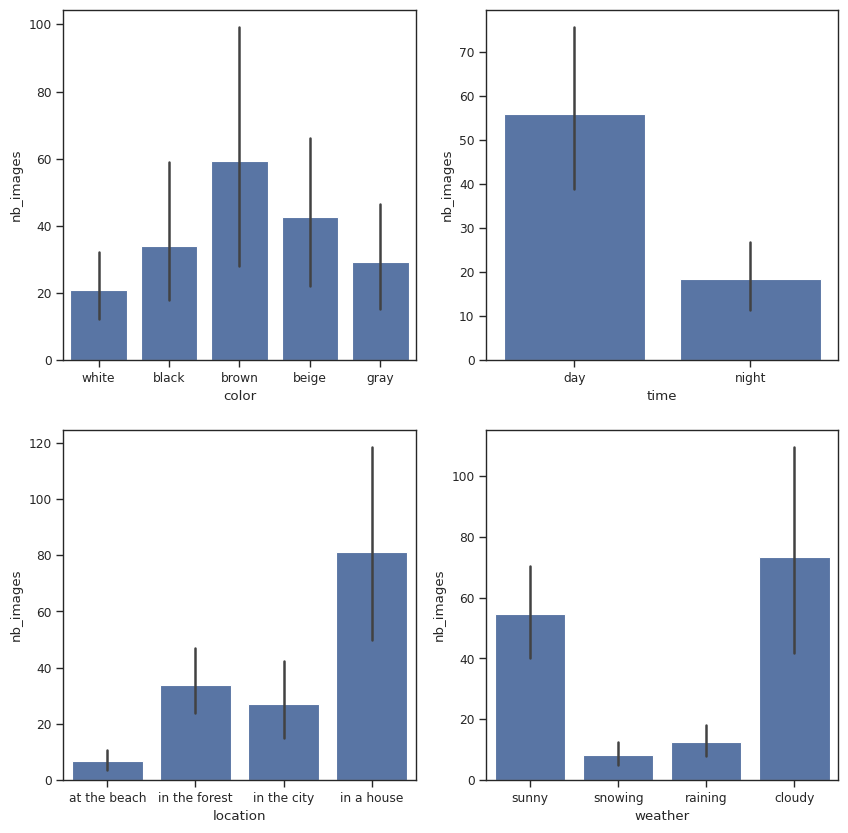

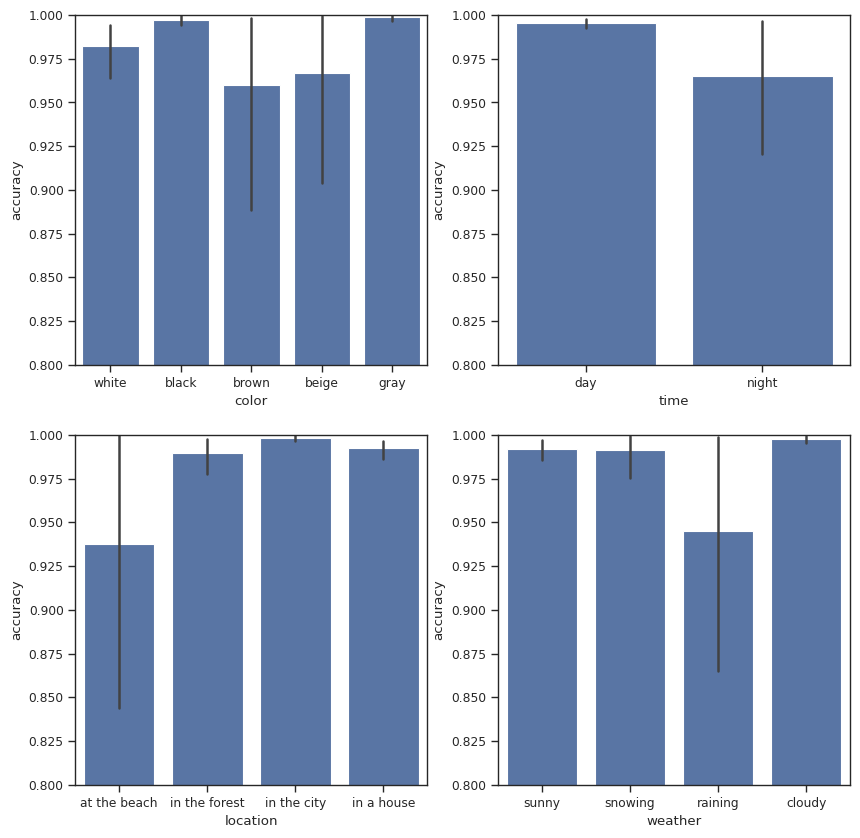

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, attribute in enumerate(['color', 'time', 'location', 'weather']):
    sns.barplot(df, x=attribute, y='nb_images', ax=axs.flatten()[i])

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, attribute in enumerate(['color', 'time', 'location', 'weather']):
    sns.barplot(df, x=attribute, y='accuracy', ax=axs.flatten()[i])
    axs.flatten()[i].set_ylim(0.8, 1)

In [22]:
word = 'raining'
idx = [i for i, p in enumerate(pred_prompts) if word in p]
print(f'global accuracy when [{word}]: {np.mean(all_correct[idx])}')

global accuracy when [raining]: 0.988
